<a href="https://colab.research.google.com/github/BlackCurrantDS/ATiML-Project/blob/master/BOG_TFIDF_WithoutNouns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import nltk
books = pd.read_csv("books_withoutNouns.csv")

In [0]:
books['len'] = books['data'].apply(len)

In [0]:
books

In [0]:
def transform_tag(var):
    """Transforms a string to a string of pos_tag"""
    inpt = nltk.pos_tag(word_tokenize(var))
    unzipped = zip(*inpt )
    return ' '.join([*list(unzipped)[1]])

In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:

#last 5
#books['data'] = books['data'].apply(lambda x: str(x)[-2000:])
#first 5
books['data'] = books['data'].apply(lambda x: str(x)[:100])
# random 2/3
#books['NData'] = books['NData'].apply(lambda x: x[3000:int(len(x)*1/3)])


In [0]:
#last 5
#df['n'] = df['data'].apply(lambda x: str(x)[-5:])
#first 5
#df['n'] = df['data'].apply(lambda x: str(x)[:5])
# random 2/3
#df['Sdata'] = df['data'].apply(lambda x: x[5:int(len(x)*2/3)])

In [0]:
#len(books['new'][2])
books.head(5)
#https://stackoverflow.com/questions/38838015/slicing-strings-in-a-column-in-pandas

,Unnamed: 0,id,genre,data
0,0,0,Sea and Adventure,dedicated brother allan melville long ago publ...
1,1,1,Sea and Adventure,voyaging straight maramma lived reigned myster...
2,2,2,Sea and Adventure,slender girl long tan coat white tamoshanter f...
3,3,3,Sea and Adventure,heart great hill land glenavelin stretch west ...
4,4,4,Sea and Adventure,yarn day clipper sailingship zenith glory reno...


In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
def counting_a(a, analysis):
    """
    Generates the tf-idf counting dataframe. First argument is the n of n-gram. Analysis type is 'word', 'char',
    token_pos', etc.
    """
    df_train = books.copy()
    
    #if we are counting words:
    if analysis == "word" or analysis == "char": 
        
        #check the CountVectorizer doc
        #we create a Countvectorizer, called bow_transformer
        # tokenizer = lambda x: x.split("<some_space>")
        bow_transformer = CountVectorizer(analyzer = analysis,
                                      lowercase = True, #we don't care about place in sentence
                                      ngram_range = (a, a),
                                      stop_words='english')

        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['data'])
        
        #we use bow_transformer to transform our test set. 
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        
    
    #if we are counting POS:    
    elif analysis == "token_pos":
        
        #this is the punctuation we want to keep
        punctuation = r"(?u)\b\w\w+\b|!|\?|\"|\'|\.|\,|\;|\:|\$|\(|\)|\--|\&|\``|\'' + PRP$ + WP$"
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = 'word',
                                          lowercase = False, #we DO care about place in sentence
                                          ngram_range = (a, a),
                                          token_pattern =  punctuation, #we DO care about punctuation
                                          stop_words='english')
        
        #we use the transform_tag function to transform the sentence in a sentence of pos tag        
        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['data'].apply(transform_tag))
        #we use bow_transformer to transform our test set
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        

        
    #this is the DataFrame Concerning the regular counting of words
    
    ##from regular counting to tf idf transformation coefficient
    tv = TfidfTransformer()
    tfidf_transformer = tv.fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    
    
    names = bow_transformer.get_feature_names()
    
    return (messages_tfidf, names)

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
#mat_word, name_word, mat_word_test = counting_a(2,'word')
mat_word, name_word = counting_a(2,'word')

print ('Shape of Sparse Matrix: ', mat_word.shape)
print ('Amount of Non-Zero occurences: ', mat_word.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_word.nnz /
                             (mat_word.shape[0] * mat_word.shape[1])))


Shape of Sparse Matrix:  (40, 10268)
Amount of Non-Zero occurences:  10659
sparsity: 2.60%


In [0]:
def top_tfidf_feats(row, features, top_n=15):
    """Gets top n tf-idf values in row and return them with their corresponding feature names."""
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [0]:
def top_feats_in_doc(Xtr, features, row_id, top_n=10):
    """Returns the top n tf-df features in a specific document (i.e. matrix row)"""
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [0]:
#,
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=.01, top_n=20 ):
    """
    Returns the top n features that on average are most important amongst documents in rows.
    Indentified by indices in grp_ids.
    """
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()
        
    #print(D)
    D[D < min_tfidf] = 0
    #D[D > max_df] = 0
    #print(D[D < min_tfidf])
    tfidf_means = np.mean(D, axis=0)
    #print(tfidf_means)
    return top_tfidf_feats(tfidf_means, features, top_n)

  #https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

In [0]:
#"""min_tfidf=.10,"""
def top_feats_by_class(Xtr, y, features, min_tfidf=.01, top_n=20):
    """
    Return a list of dfs, where each df holds top_n features and their mean tfidf value.
    Calculated across documents with the same class label.
    """
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n ) #min_tfidf=min_tfidf,
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [0]:
import matplotlib.pyplot as plt

def plot_tfidf_classfeats_h(dfs, name = 'default'):
    """Plot the data frames returned by the function plot_tfidf_classfeats()."""
    fig = plt.figure(figsize=(50, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-5,5))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=1, left=.9, top=0.95, wspace=1)
        fig.tight_layout()
    #this line is for saving as picture
    plt.savefig(name)
    #this line is for showing
    plt.show()

In [0]:
mat_word, name_word = counting_a(2,'word')
alpha_word = top_feats_by_class(mat_word, books.genre, name_word)

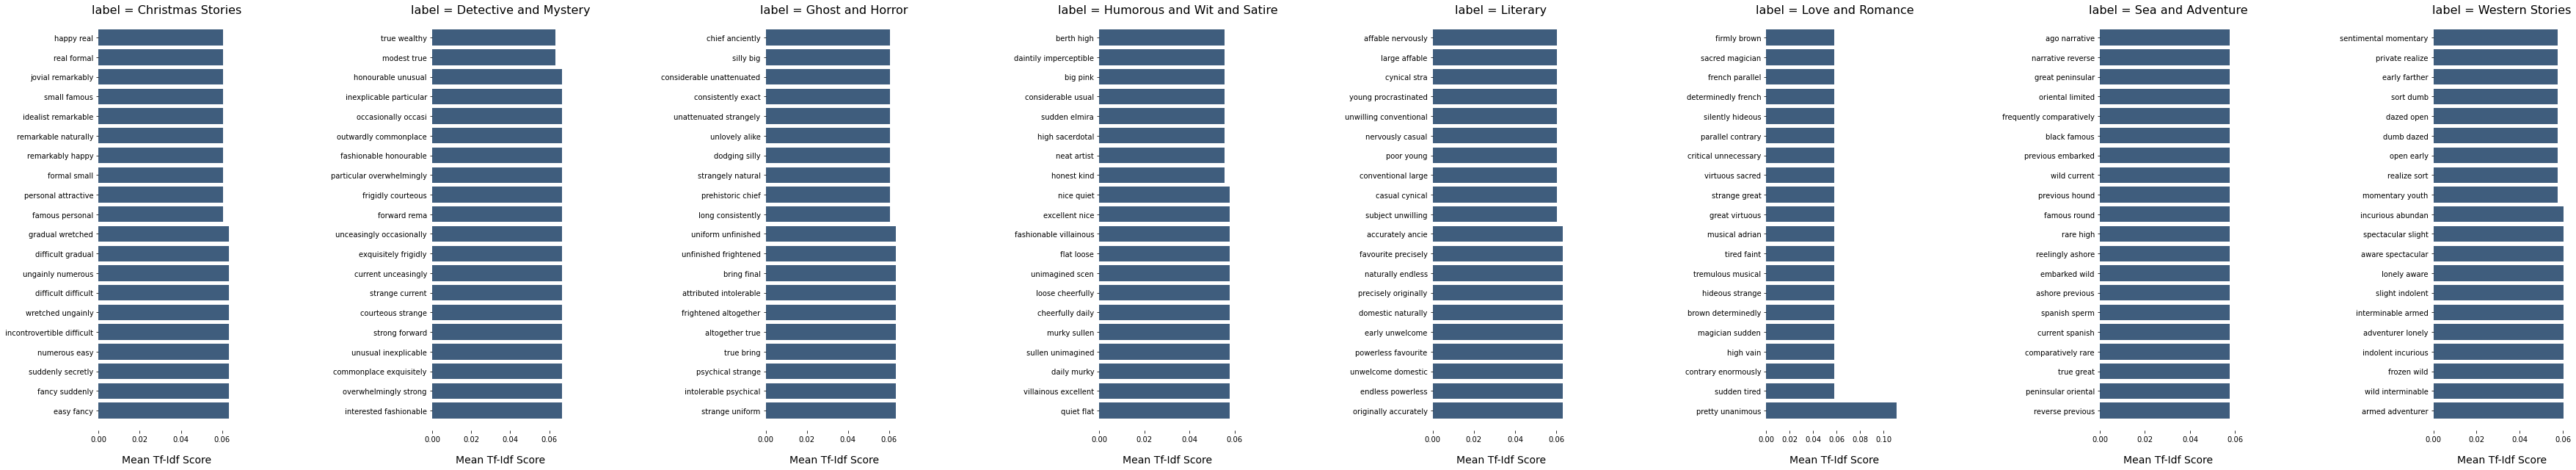

In [45]:
plot_tfidf_classfeats_h(alpha_word, 'bi_gram_word')